<a href="https://colab.research.google.com/github/on-kulyashov/RQC-projects/blob/main/fermions_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

H = [[ 3.  2.  2. -0.]
 [ 2. -3. -0.  2.]
 [ 2. -0. -3.  2.]
 [-0.  2.  2.  3.]]
Eigenvec = 
[[-3.16227766e-01 -1.29526020e-16 -7.07106781e-01 -6.32455532e-01]
 [ 6.32455532e-01  7.07106781e-01 -5.19786468e-17 -3.16227766e-01]
 [ 6.32455532e-01 -7.07106781e-01  1.05030599e-16 -3.16227766e-01]
 [-3.16227766e-01 -2.22044605e-16  7.07106781e-01 -6.32455532e-01]]
H = [[ 3.  2.  2. -0.]
 [ 2. -3. -0.  2.]
 [ 2. -0. -3.  2.]
 [-0.  2.  2.  3.]]
Eigenvec = 
[[-3.16227766e-01 -1.29526020e-16 -7.07106781e-01 -6.32455532e-01]
 [ 6.32455532e-01  7.07106781e-01 -5.19786468e-17 -3.16227766e-01]
 [ 6.32455532e-01 -7.07106781e-01  1.05030599e-16 -3.16227766e-01]
 [-3.16227766e-01 -2.22044605e-16  7.07106781e-01 -6.32455532e-01]]
H = [[ 3.  2.  2. -0.]
 [ 2. -3. -0.  2.]
 [ 2. -0. -3.  2.]
 [-0.  2.  2.  3.]]
Eigenvec = 
[[-3.16227766e-01 -1.29526020e-16 -7.07106781e-01 -6.32455532e-01]
 [ 6.32455532e-01  7.07106781e-01 -5.19786468e-17 -3.16227766e-01]
 [ 6.32455532e-01 -7.07106781e-01  1.05030599e-16

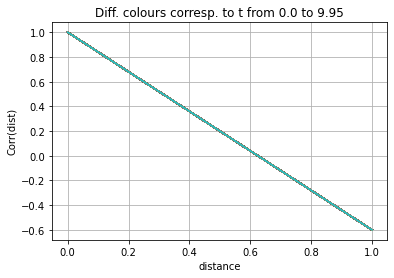

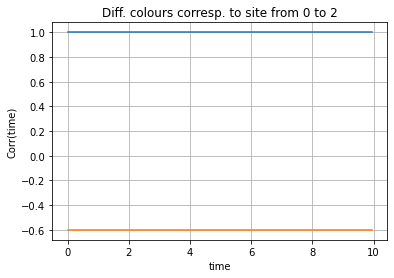

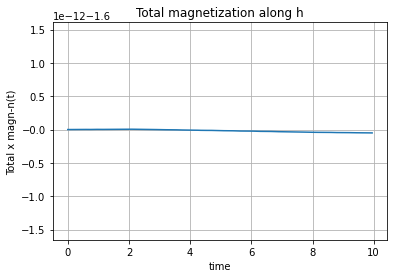

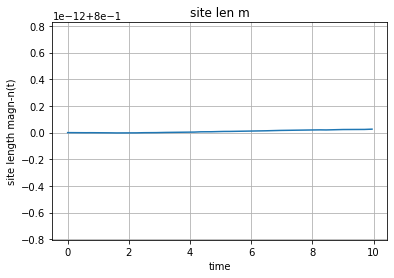

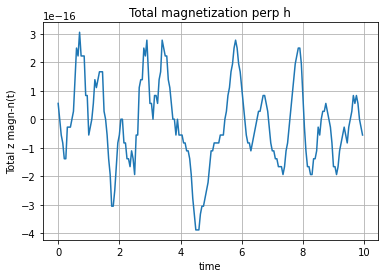

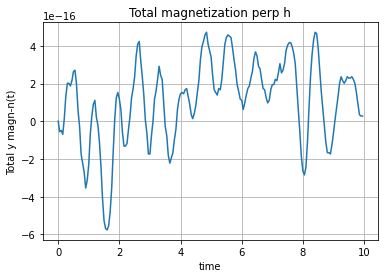

In [ ]:
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import expm, sinm, cosm
from scipy.integrate import quad
from sklearn.preprocessing import normalize
 
# np.set_printoptions(precision=2)
 
 
# with open('test_fermi') as f:
#     h = list(map(float, (f.readline()).split(" ")))
#     j = list(map(float, (f.readline()).split(" ")))
#     T = float(f.readline())
# n = len(h)
 
n = 2

# hmax = 0.5
# T1, T2 = 0.5, 2  # 0.001, 0.033
# seed = 53
# np.random.seed(seed)
# j = np.random.uniform(size=(n-1))
# h = np.random.uniform(0, hmax, size=n)
# T = np.random.uniform(T1,T2)
# with open('test_fermi', "w") as f: # for first compilation change w to x
#     f.write(str(h) + " \n " + str(j) + " \n " + str(T))
 
 
# long-distance limit
# g = hmax # g = 1 - critical, g must be close to one 
# a = 0.01 # goes to zero
# J = 3 # goes to infinity
# c = 2 * J * a
# delta = 2 * J * (1 - g)
# z = J**(-0.25)
time = np.arange(0,10,0.05)
T = 0
j1 = -3 * np.full(n, 1)
j2 = -3 * np.full(n, 1)
h1 = -2 * np.full(n, 1)
h2 = -2 * np.full(n, 1)
 
def f_i(s):
    def integrand(y):
        return np.log(np.tanh((y**2 + s**2)**(0.5) / 2))
    return abs(s) * np.heaviside(s, 0.5) - (1 / np.pi) * quad(integrand, 0, float('inf'))[0]
 
 
def g_i(s):
    def integrand(y):
        def integrand_f(w):
            return y / (np.sinh(np.sqrt(y**2 + w**2))*np.sqrt(y**2 + w**2))
        a = 0
        if y <= 0:
            a = -1
        return (a  + (1 / np.pi) * quad(integrand_f, 0, float('inf'))[0])**2 / y
    return np.exp(quad(integrand, s, float('inf'))[0]) + np.log(s) / 4
 
 
def sigma_z_ld(x):
    return z * T**(0.25) * g_i(delta / T) * np.exp(-T*abs(x)*f_i(delta / T) / c)
 
 
# ising limit
 
def ising_correl(x):
    # for periodic border
    # lmin = 2 * np.sinh(J / T)
    # lpls = 2 * np.cosh(J / T)
    # z = lmin**n + lpls**n
    # return ((lmin**x) * (lpls**(n-x)) + (lpls**x) * (lmin**(n-x))) / z
    return np.tanh(J / T)**x
 
 
# direct solution
pauli = np.array([ [[0,1],[1,0]], [[0,-1j],[1j,0]], [[1,0],[0,-1]] ])
dbl_pauli = np.array([np.kron(a,a) for a in pauli])
 
# hamiltonian construction
def Hamiltonian(h, j):
    H = np.zeros(2**n)
    for i in range(n-1):
        H = H + j[i]*np.kron(np.kron(np.eye(2**i), dbl_pauli[2]), np.eye(2**(n-2-i)))
    for i in range(n):
        H = H + h[i]*np.kron(np.kron(np.eye(2**i), pauli[0]), np.eye(2**(n-1-i)))
    print("H = {}".format(-np.real_if_close(H)))
    print("Eigenvec = \n{}".format(np.linalg.eigh(-np.real_if_close(H))[1]))
    return -np.real_if_close(H)


def direct_evolution(state, dt):
    # print("projection+ = {}".format(np.sqrt(np.real_if_close(np.matmul(np.array([[0.5,0.5,0.5,0.5]]), np.matmul(state, np.transpose(np.array([[0.5,0.5,0.5,0.5]]))))))))
    u = expm(-dt*1j*Hamiltonian(h2, j2))
    uH = np.conj(np.transpose(u))
    return np.matmul(u, np.matmul(state, uH))

def integrate(f, sol0, time):
    sol = [sol0]
    for i in range(1, len(time)):
        sol.append(f(sol[-1], (time[i] - time[i-1])))
    return sol

def magn_total_direct(state, direction):
    magn = np.zeros(2**n)
    for i in range(n):
        magn = magn + np.kron(np.kron(np.eye(2**i), pauli[direction]), np.eye(2**(n-1-i)))
    # print("magn = {}".format(magn))
    return np.trace(np.matmul(state, magn))

def magn_site_direct(state, direction, i):
    magn = np.kron(np.kron(np.eye(2**i), pauli[direction]), np.eye(2**(n-1-i)))
    # print("state = \n{}".format(state))
    # print("magn = \n{}".format(magn))
    return np.trace(np.matmul(state, magn))

def initial_state_direct(temperature, hamilt):
    if temperature:
        dens_direct = expm(-hamilt / temperature)
        dens_direct = dens_direct / np.trace(dens_direct)
        return dens_direct
    else:
        # print("init hamilt = \n {}".format(hamilt))
        E, V = np.linalg.eigh(hamilt)
        E = np.real_if_close(E)
        V = np.real_if_close(V)
        idx = np.argsort(E)
        E = E[idx]
        # print("energies = {}".format(E))
        V = V[:,idx]
        # print("initial vector = {}".format(V[:,0]))
        return np.tensordot(V[:,0], np.transpose(V[:,0]), axes=0)


# initial_state_direct(hamilt, T)
# correlator construction
def sigma_z(i, j):
    if i - j:
        return np.real(np.kron(np.kron(np.kron(np.kron(np.eye(2**i), pauli[2]), np.eye(2**(j-i-1))), pauli[2]), np.eye(2**(n-j-1))))
    return np.real(np.kron(np.kron(np.eye(2**i), np.matmul(pauli[2], pauli[2])), np.eye(2**(n-i-1))))
 
def s_direct(i0, j0, dens_direct):
    i = min(i0, j0)
    j = max(i0, j0)
    # print("correl  = \n{}".format(sigma_z(i,j)))
    # thermal state
    return np.trace(np.matmul(dens_direct, sigma_z(i,j)))
    # ground state
    # return (np.matmul(np.transpose(V[:,0]), np.matmul(sigma_z(i,j), V[:,0])))

# Young's solution
 
def hamiltonian(h, j):
    print("size = {}".format(n))
    mid = np.zeros((n, n))
    up = np.zeros((n, n))
    dn = np.zeros((n, n))
    for i in range(n):
        mid[i][i] = float(h[i])
    for i in range(n-1):
        up[i][i+1] = float(j[i]) / 2 # divided by two
        dn[i+1][i] = float(j[i]) / 2 # divided by two
    a = (mid - up - dn)
    b = -(up - dn)
    return np.block([[a, b], [-b, -a]])

def occup_num(old_oc_num, old2new, newEnergies, time):
    # old_oc_num = (nu1, nu2, ..., (1 - nu1), (1 - nu2), ...)
    # newEnergies = (e1, e2, ..., -e1, -e2, ...)
    # old2new = (2n) x (2n) transitoin matrix: newGammaNambu = old2new * oldGammaNambu 
    evol = np.diag(np.exp(-1j*time*newEnergies))
    a = np.matmul(old2new, np.matmul(evol, np.transpose(old2new)))
    a = np.abs(a)**2
    oc_num = np.matmul(a, old_oc_num)
    return oc_num

def old2new(oldU, newU):
    return np.transpose(np.transpose(newU), oldU)

e, u = np.linalg.eigh(hamiltonian(h, j))
idx = np.argsort(e)[::-1]
e = e[idx]
e = np.concatenate((e[:n], e[-1:n-1:-1]))
u = u[:,idx]
u = np.concatenate((u[:,:n], u[:,-1:n-1:-1]), axis=1)
u1 = u[:,:n]
phi = np.transpose(u1[:n,:] + u1[n:,:])
psi = np.transpose(u1[:n,:] - u1[n:,:])

def oc_num_0(T, e):
    if T:
        nums = (1 / (1 + np.exp(2 * e[:n] / T)))
        return oc_num_0 = np.concatenate((nums, 1 - nums))
    return oc_num_0 = np.concatenate((np.zeros(n), np.ones(n)))

def correl_mat(psi, phi, oc_num)
    oc_num = np.diag(oc_num[:n])
    return -np.matmul(np.transpose(psi), np.matmul((np.eye(n) - 2*oc_num), phi))
 
def s(i0, j0):
    i = min(i0, j0)
    j = max(i0, j0)
    wick = g[i:j, (i+1):(j+1)]
    return np.linalg.det(wick)
  
def fit_func(x, l):
    return np.exp(-x/l)
 
start = 0
finish = n
# correlations = np.array([s(start, x) for x in range(start, finish)])
# corr_direct = np.real_if_close(np.array([s_direct(start, x) for x in range(start, finish)]))
# norm = corr_direct[0]
# corr_direct = corr_direct / norm
dist = np.arange(n)
# popt, pcov = curve_fit(fit_func, dist, correlations)
# plt.plot(dist, correlations, 'r-', linewidth=2.0)
# plt.plot(dist, fit_func(dist, *popt), 'r--', linewidth=2.0)
# # plt.plot(dist, ising_correl(dist), 'm-', linewidth=2.0)
# # plt.plot(dist, sigma_z_ld(dist), 'b-', linewidth=2.0)
# plt.plot(dist, corr_direct, 'g-', linewidth=2.0)
# plt.xlabel("distance")
# plt.ylabel("Corr(dist)")
# plt.legend(["Correlations", "Exp fit", "Direct"])
# plt.title("H_max / J_max = {}, T = {}, Corr len = {}".format(np.round(hmax,2), np.round(T,4), np.round(*popt,2)))
# plt.grid()
# plt.show()
dens_evol = integrate(direct_evolution, initial_state_direct(T, Hamiltonian(h1, j1)), time)
dens0 = dens_evol[0]
# print(dens0)
# print(magn_site_direct(dens0, 0, 1))
# print(magn_site_direct(dens0, 1, 1))
# print(magn_site_direct(dens0, 2, 1))
corr_direct_time_space = np.array([[np.real_if_close(s_direct(0, x, dens)) for dens in dens_evol] for x in range(start, finish)])
for t in range(len(time)):
    plt.plot(dist, corr_direct_time_space[:,t])
plt.xlabel("distance")
plt.ylabel("Corr(dist)")
plt.title("Diff. colours corresp. to t from {} to {}".format(np.round(time[0], 2), np.round(time[-1], 2)))
plt.grid()
plt.show()

for x in range(n):
    plt.plot(time, corr_direct_time_space[x,:])
plt.xlabel("time")
plt.ylabel("Corr(time)")
plt.title("Diff. colours corresp. to site from 0 to {}".format(n))
plt.grid()
plt.show()

magn_evol_longt = np.array([np.real_if_close(magn_total_direct(dens, 0)) for dens in dens_evol])
plt.plot(time, magn_evol_longt)
plt.xlabel("time")
plt.ylabel("Total x magn-n(t)")
plt.title("Total magnetization along h")
plt.grid()
plt.show()

magn_evol_trans1 = np.array([np.sqrt(abs(magn_site_direct(dens, 0, 1))**2 + abs(magn_site_direct(dens, 1, 1))**2 + abs(magn_site_direct(dens, 2, 1))**2)  for dens in dens_evol])
plt.plot(time, magn_evol_trans1)
# magn_evol_trans0 = np.array([np.sqrt(abs(magn_site_direct(dens, 0, 0))**2 + abs(magn_site_direct(dens, 1, 0))**2 + abs(magn_site_direct(dens, 2, 0))**2)  for dens in dens_evol])
# plt.plot(time, magn_evol_trans0)
# plt.yscale('log')
plt.xlabel("time")
plt.ylabel("site length magn-n(t)")
plt.title("site len m")
plt.grid()
plt.show()

magn_evol_trans = np.array([np.real_if_close(magn_total_direct(dens, 2)) for dens in dens_evol])
plt.plot(time, magn_evol_trans)
# plt.yscale('log')
plt.xlabel("time")
plt.ylabel("Total z magn-n(t)")
plt.title("Total magnetization perp h")
plt.grid()
plt.show()

magn_evol_trans = np.array([np.real_if_close(magn_total_direct(dens, 1)) for dens in dens_evol])
plt.plot(time, magn_evol_trans)
# plt.yscale('log')
plt.xlabel("time")
plt.ylabel("Total y magn-n(t)")
plt.title("Total magnetization perp h")
plt.grid()
plt.show()